In [639]:
# ridge svd?
#wanna go QR _or_ cholesky or what its called? check monday
#expand a bit to allow looping over noise weights?
#first mse r2 for low N?
#Most kFold versions look similar. introduce a "method" parameter and consolidate
#bias also increases with model complexity?

#validation set too?
#CENTER DATA?
#program likes cubic input, fix
# Ridge, 0 lambda best?
#VARIANCES SAME?!?!?!!?

#split in 3, train test to find poly degree, then use thiese betas with validation set to adjust hyperparameters?

In [640]:
#import packages
import numpy as np
from imageio import imread
from random import random, seed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
import scipy.linalg as scl
from sklearn.model_selection import KFold
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [641]:
"""
This is an "uglified" version of the FrankeFunction, to minimize use of costly functions like divisions and powers.
It takes as input parameters a meshgrid of coordinates in the x and y direction.
"""
def FrankeFunction(x,y): #still got one division in here
    term1 = 0.75*np.exp(-(0.25*(9*x-2)*(9*x-2)) - 0.25*((9*y-2)*(9*y-2)))
    term2 = 0.75*np.exp(-((9*x+1)*(9*x+1))/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)*(9*x-7)*0.25 - 0.25*((9*y-3)*(9*y-3)))
    term4 = -0.2*np.exp(-(9*x-4)*(9*x-4) - (9*y-7)*(9*y-7))
    return term1 + term2 + term3 + term4

In [642]:
"""
This function creates the Model Matrix, usually dubbed X, for regression analysis.
It takes as input parameters a meshgrid of coordinates in the x and y direction, 
and the polynomial degree P that you wish to fit.

The order of columns is different from the one scikit learn creates, so take care to use the same model-creator when
comparing scikit and this code.

The ordering this function creates is: x^0y^0, x^1y^0, x^2y^0, x^0y^1, x^1y^1, x^0y^2 for a 2nd order polynomial.
"""
def Model(x,y,P): 
    m = len(x)*len(y) # number of equations
    t = sum(range(P+2)) # number of terms in polynomial
    X = np.zeros((m,t)) # Model matrix
    a = np.matrix.flatten(x)
    b = np.matrix.flatten(y)
    c = 0 #counter
    for i in range(P+1):
        for j in range(P+1-i):
            X[:,c] = a**j*b**i
            c +=1
    return X

In [643]:
def ols_svd(X: np.ndarray, z: np.ndarray,_lambda) -> np.ndarray:
    u, s, v = scl.svd(X)
    pin = scl.diagsvd(1./s,len(v),len(u))
#     return v.T @ scl.pinv(scl.diagsvd(s, u.shape[0], v.shape[0])) @ u.T @ z
    return v.T @ pin @ u.T @ z
#pinx xt x
# THIS ALGO NEEDS IMPROVEMENT! QR decomp

#same results as skl up to and including mpd14

In [644]:
def ols_inv(X: np.ndarray, z: np.ndarray) -> np.ndarray:
    return scl.inv(X.T @ X) @ (X.T @ z)

In [645]:
"""
Just a standard R2 score calculator, taking the measured/real data as the first input, and the values the 
regression model finds as the second input
"""
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

In [702]:
"""
Standard mean squared error calculator, inputs are measured/real data and regression model values.
"""
def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

In [703]:
#define variance function
def Var(y_data, y_model,X,_lambda):
    N = len(y_data)
    covar = np.linalg.inv(X.T.dot(X))#sigma2, should be 1 in this case
    vari = np.diagonal(covar)
    return vari

In [792]:
def VarRidge(X,_lambda): #sigma2?
    XX = X.T@X
#     print(np.shape(X))
#     print(XX)
    invers = np.linalg.inv(XX+_lambda*np.eye(len(XX)))
#     ai = invers@XX@(invers.T)
#     bi = np.diagonal(ai)
#     return np.linalg.inv(XX+_lambda*np.eye(len(XX)))@XX@(np.linalg.inv(XX+_lambda*np.eye(len(XX))).T)
    return np.diagonal(invers)

In [783]:
X = Model(x,y,1)
_lambda = 0

VarRidge(X,_lambda)

array([0.01737947, 0.02957705, 0.03305164])

In [704]:
# def Var2(y_data,y_model,n):
#     m = len(y_data)
#     res = y_data-y_model
#     return (1./(m-n-1))*(res.T@res)
# #     return np.mean(y_model**2)-np.mean(yh)

In [705]:
def Bias(y_data, y_model, P, X):
    N = len(y_data) #should probably insert z here
    # also want the expectation values
    #this is where i want to shuffle my data and do 10 kfolds.
    #maybe...
    #can not use each fold and create a mean from them?
    return np.sum((y_data-y_model)*(y_data-y_model))/N

In [706]:
# def Bias2(y_data,y_model):
#     n = len(y_data)
#     return np.sum((y_data-(np.mean(y_model)))**2)/n

In [827]:
#Create random variables/predictors
# np.random.seed(1234)
N = 20 #number of points along x and y axes

# sort this for meshgrid
x = np.random.uniform(0,1,N)
y = np.random.uniform(0,1,N)

x = sorted(x)
y = sorted(y)
x, y = np.meshgrid(x,y,sparse=False)

#create datapoints/results
z = FrankeFunction(x, y)

# Create noise
noise_weight = 0.1 #might wanna make a function for this to loop over weights?
Noise = noise_weight*np.random.randn(N,N)

#add noise
z_n = z+Noise

#flatten for use in functions
z_n = np.matrix.flatten(z_n) ##### RAVEL?
z = np.matrix.flatten(z)

#added a 0 Ridge parameter
_lambda = 0.0

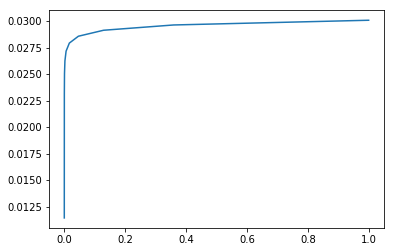

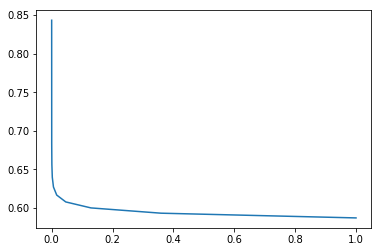

In [714]:
pd = 5
# _lams = np.linspace(0.0,1.,100)
_lams = np.logspace(-4,0,10)

X = Model(x,y,pd)
fish=[]
rish=[]
z_n_sorted = sorted(z_n)
# X = X-np.mean(X,axis=0)
# X_c[:,0]=1.
# z_n = z_n -np.mean(z_n)
for i in range(len(_lams)):
    fish.append(MSE(kFoldRidge(k,X,z_n,i)[0],z_n_sorted))
    rish.append(R2(z_n_sorted,kFoldRidge(k,X,z_n,i)[0]))
plt.figure()
plt.plot(_lams,fish)
plt.show()
plt.figure()
plt.plot(_lams,rish)
plt.show()

[1.00000000e-04 2.78255940e-04 7.74263683e-04 2.15443469e-03
 5.99484250e-03 1.66810054e-02 4.64158883e-02 1.29154967e-01
 3.59381366e-01 1.00000000e+00]


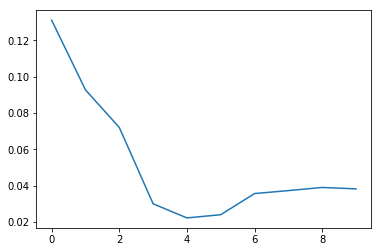

In [717]:
# _lammy = np.logspace(0,-4,10)
_lammy = np.logspace(-4,0,10)
print(_lammy)
# aham = kFoldLassoCV(k,X,z_n,_lammy)
# aham.mse_path_

reg = skl.LassoCV(alphas=_lammy,cv = k, random_state = 0,tol=0.0001,max_iter = 10000000).fit(X,z_n)
plt.plot(np.mean(reg.mse_path_,axis=0))#_lammy x-ax

In [699]:
MPD =3#maximal polynomial degree

X = Model(x,y,MPD) #create model matrix

X_c = X-np.mean(X,axis=0)
# X_c[:,0]=1.
z_c = z_n -np.mean(z_n)
# print(np.shape(X_c))
print(X_c)

[[ 0.         -0.55425331 -0.38757057 ... -0.37828516 -0.21802365
  -0.28893241]
 [ 0.         -0.3765023  -0.35108044 ... -0.37828516 -0.21701361
  -0.28893241]
 [ 0.         -0.29542915 -0.31345341 ... -0.37828516 -0.21655293
  -0.28893241]
 ...
 [ 0.          0.30791088  0.37949784 ...  0.48678296  0.54461685
   0.52317141]
 [ 0.          0.31461944  0.39129534 ...  0.48678296  0.55045833
   0.52317141]
 [ 0.          0.3901176   0.53027088 ...  0.48678296  0.61619839
   0.52317141]]


In [604]:
def NoResampling(X,z_n,_lambda):
#     beta = np.linalg.inv(X.T.dot(X)+_lambda*np.eye(len(X[0][:]))).dot(X.T).dot(z_n)
    beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(z_n)
#     beta = ols_svd(X,z_n,_lambda)
#     beta = ols_inv(X,z_n)
    ztilde = X @ beta
#     print(ztilde)
#     print(z_n)
#     return ztilde
    return MSE(z_n,ztilde), R2(z_n,ztilde)

In [605]:
print(NoResampling(X,z_n,0))

print(NoResampling(X_c,z_c,0))


(0.016017131181183576, 0.7802152682201866)
(0.016017131181183572, 0.7802152682201866)


In [606]:
## find parameters
beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(z_n)
# beta = ols_svd(X,z_n,_lambda)
# beta=ols_inv(X,z_n)
## make prediction
ztilde = X @ beta

In [607]:
######  Makes model matrix, looks different than mine #####
# form: x0y0, x1y0, x0y1, x2y0, x1y1, x0y2
# poly2 = PolynomialFeatures(degree=MPD)
# a = x[:,np.newaxis]
# b = y[:,np.newaxis]
# cc = np.c_[a,b]
# Xskl = poly2.fit_transform(cc) 
##########################################################
# THIS CELL IS CURRENTLY NOT IN USE #

In [608]:
# find parameters
clf = skl.LinearRegression(fit_intercept=False) #False to not center data, i.e. intercept is not 0
clf.fit(X,z_n) 

#make prediction
zpredict = clf.predict(X)

In [609]:
# The mean squared error              
print("Mean squared error (self): %.5f" % MSE(z_n, ztilde))
print("Mean squared error (skl): %.5f" % mean_squared_error(z_n, zpredict))

# Explained variance score: 1 is perfect prediction     
print('R2 score (self): %.5f' %R2(z_n, ztilde))
print('R2 score (skl): %.5f' % r2_score(z_n, zpredict))


Mean squared error (self): 0.01602
Mean squared error (skl): 0.01602
R2 score (self): 0.78022
R2 score (skl): 0.78022


In [610]:
print(Var(z_n, ztilde, MPD,X)) #my variances in betas
print(Var(z_n,zpredict,MPD,X)) #skl variances in betas

[ 0.47467027  6.56726867 18.93646067  7.39431994 10.1288959  20.95837442
  8.37931542 31.51230859  9.81050606 11.63613245]
[ 0.47467027  6.56726867 18.93646067  7.39431994 10.1288959  20.95837442
  8.37931542 31.51230859  9.81050606 11.63613245]


In [611]:
print(beta) #my betas
print(clf.coef_) #skl betas

[ 1.04122907 -1.07631983 -0.59151612  0.38273037  1.2485895   3.14667013
  0.36548994 -6.98683635 -2.7315274   5.30937872]
[ 1.04122907 -1.07631983 -0.59151612  0.38273037  1.2485895   3.14667013
  0.36548994 -6.98683635 -2.7315274   5.30937872]


In [612]:
std = 1.96*np.sqrt(abs(Var(z_n, ztilde, MPD,X))) ###ABS??

for i in range(len(std)):
    print(beta[i],std[i])
#these things are huge, something is probably off

1.0412290712418346 1.3503678408072208
-1.0763198290275364 5.0228298115604835
-0.5915161232731321 8.529144582593162
0.38273037110232755 5.329729774454308
1.2485894962518913 6.237881569933589
3.1466701261142864 8.972942169065307
0.36548993646141104 5.673621251869044
-6.9868363513044525 11.002621718258235
-2.73152740288469 6.139058565494185
5.309378722546542 6.685908046752479


In [613]:
# 95% CI: mu +-1.96*sigma
print(np.shape(X),np.shape(z_n))

(400, 10) (400,)


In [614]:
def ksajjad(X,z,k):
    k = int(np.math.ceil((1./k)*len(X))) ##ADDED this line, show sajjad
    n,m = np.shape(X)
    ind = np.arange(0,n,k)
    for i in ind:
        X_test, z_test = X[i:(i+k),:],z[i:(i+k)]
        if i ==0:
            X_train,z_train = X[i+k:,:],z[i+k:]
        elif i ==(n-k):
            X_train,z_train = X[:i,:],z[:i]
        else:
            X_train = np.vstack([X[:i,:],X[i+k:,:]])
            z_train = np.hstack([z[:i],z[i+k:]])
        yield X_train, X_test, z_train, z_test

In [615]:
XX = np.array([[2,2,2],[3,3,3],[4,4,4],[5,5,5],[6,6,6],[7,7,7],[8,8,8],[9,9,9],[0,0,0]])
zz = np.array([2,3,4,5,6,7,8,9,0])

for X_train, X_test, z_train, z_test in ksajjad(XX,zz,5):
    print(X_train)
    print("--------------------")

[[4 4 4]
 [5 5 5]
 [6 6 6]
 [7 7 7]
 [8 8 8]
 [9 9 9]
 [0 0 0]]
--------------------
[[2 2 2]
 [3 3 3]
 [6 6 6]
 [7 7 7]
 [8 8 8]
 [9 9 9]
 [0 0 0]]
--------------------
[[2 2 2]
 [3 3 3]
 [4 4 4]
 [5 5 5]
 [8 8 8]
 [9 9 9]
 [0 0 0]]
--------------------
[[2 2 2]
 [3 3 3]
 [4 4 4]
 [5 5 5]
 [6 6 6]
 [7 7 7]
 [0 0 0]]
--------------------
[[2 2 2]
 [3 3 3]
 [4 4 4]
 [5 5 5]
 [6 6 6]
 [7 7 7]
 [8 8 8]
 [9 9 9]]
--------------------


# b

In [616]:
k = 10 # number of folds
partition = 0.2 # percentage of data to use for testing

In [725]:
def Shuffler(X,z_n):
#     np.random.seed(1234)
    n = len(X[0,:])
    combi = np.c_[X,z_n] #combine
    np.random.shuffle(combi) #shuffle
    X, z_n = combi[:,:n], combi[:,n] #split
    return X, z_n

In [845]:
def kFold(k,X,z_n):
    #shuffle data before doing the kFold
    X,z_n = Shuffler(X,z_n)

    #initialize values
    sMSE = 0. #sum mean squared error
    sR2 = 0. #sum R2 score
    betas = []
    c = 0
    for X_train, X_test, z_train, z_test in ksajjad(X,z_n,k):
        # find parameters
        betas.append(ols_svd(X_train,z_train,0.))
#         beta = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(z_train)
    
        # make prediction
        z_tilde =X_test @ betas[c][:]
        c+=1

        #store data per fold
        sMSE += MSE(z_tilde,z_test)# --> /k
        sR2 += R2(z_test,z_tilde)
        
    return sMSE/k,sR2/k,np.mean(betas,axis=0)#,VAR SOMEHOW

In [825]:
def kFoldskl(k,X,z_n):
    #shuffle data before doing the kFold
    X, z_n = Shuffler(X,z_n)

    #initialize values
    sMSE =0.
    sR2 =0.
    
    kfold = KFold(k,shuffle=False)   
    for train,test in kfold.split(X,z_n):
        # find parameters
        clf = skl.LinearRegression(fit_intercept=False) #False to not center data, i.e. intercept is not 0
        clf.fit(X[train],z_n[train]) 

        #make prediction
        z_tilde = clf.predict(X[test])

        z_test_per_fold.append(z_n[test])
        z_tilde_per_fold.append(z_tilde)
        
    #prepare data before returning (sorting needed due to shuffles)
    z_test_per_fold = np.hstack(z_test_per_fold)
    z_tilde_per_fold = np.hstack(z_tilde_per_fold)
    order = np.argsort(z_test_per_fold)
    z_tilde_per_fold = z_tilde_per_fold[order]
    
    return z_tilde_per_fold, clf.coef_

In [844]:
z_n_sorted = sorted(z_n)
X = Model(x,y,1)
print(kFold(k,X,z_n)[2])
print(R2(kFoldRidge(k,X,z_n,0.)[0],z_n_sorted))
print(R2(kFoldskl(k,X,z_n)[0],z_n_sorted))

(10, 3)
[ 1.00542968 -0.38293139 -0.78580191]
0.5342139363655622
0.5332739803839501


In [816]:
#Run NN kFolds to create bias/variance plot
#My bias increases again with model complexity
NN=5
mpd = 15
qq = len(z_n)

#sort noisy signal
z_n_sorted = sorted(z_n)

#initialize variables 
NMSE_k = np.zeros(shape=(NN,mpd)) #MSE stored for each run of kFold
model_values = np.zeros(shape=(NN,mpd,qq))
bias2 = np.zeros(mpd)
var = np.zeros(mpd)
bias2_ = np.zeros(shape=(mpd,qq))
var_ = np.zeros(shape=(mpd,qq))

# betas = np.zeros(shape=(NN,mpd))
betas=[]
#Run NN kFolds
for l in range(NN):
    #shuffle here
    for i in range(mpd):
        X = Model(x,y,i+1)
#         model_values[l,i] = kFoldskl(k,X,z_n)[0]
        model_values[l,i] = kFold(k,X,z_n)[0]
        NMSE_k[l,i] = MSE(model_values[l,i],z_n_sorted)
        if l == 0:
            betas.append(kFold(k,X,z_n)[1])
NMSE = np.mean(NMSE_k,axis=0)

#Calculate bias and variance for each polynomial degree
for i in range(mpd):
    for m in range(qq):
        bias2_[i,m] = np.mean(model_values[:,i,m])
        var_[i,m] = np.var(model_values[:,i,m])
    bias2[i]=np.mean((z_n_sorted-bias2_[i])**2)
    var[i] = np.mean(var_[i])

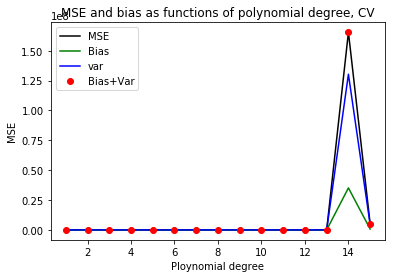

In [817]:
ols_noise = 8
legs = 'MSE','Bias','var','Bias+Var'
plt.figure()
maxi = 15
plt.plot(np.arange(1,maxi+1),NMSE[:maxi],'k')
plt.plot(np.arange(1,maxi+1),bias2[:maxi],'g')
plt.plot(np.arange(1,maxi+1),var[:maxi],'b')
plt.plot(np.arange(1,maxi+1),bias2[:maxi]+var[:maxi],'ro')
plt.xlabel('Ploynomial degree')
plt.ylabel('MSE')
plt.title('MSE and bias as functions of polynomial degree, CV')
plt.legend(legs)
plt.show()

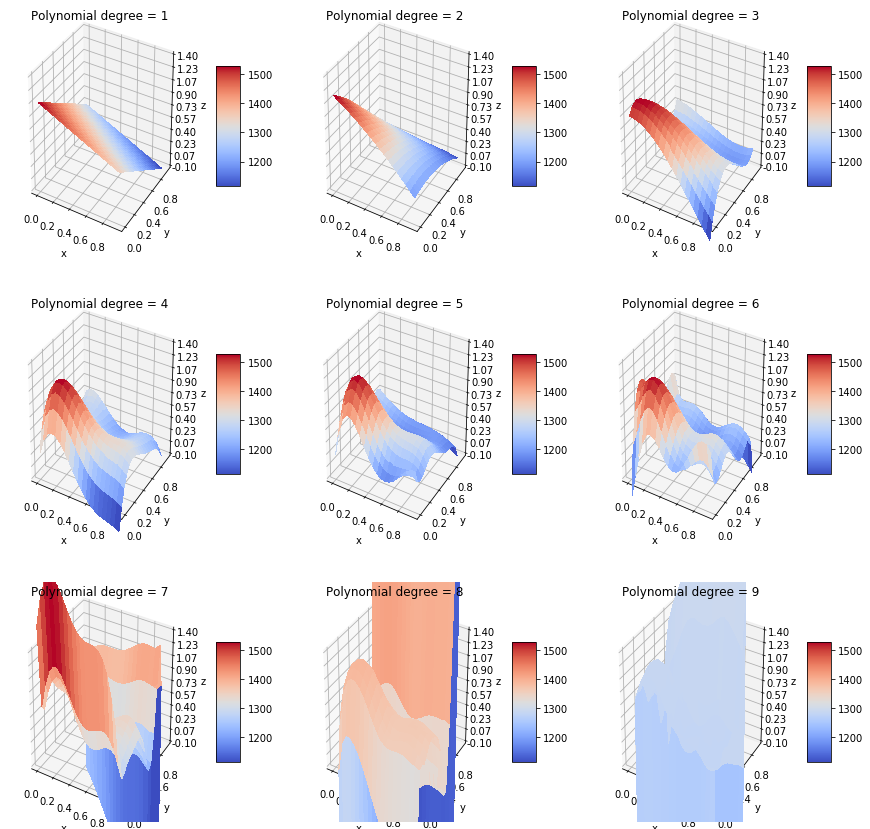

In [815]:
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
xp = np.arange(0,1,0.05)
yp = np.arange(0,1,0.05)
xp,yp = np.meshgrid(xp,yp,sparse=False)
xz,yz = np.meshgrid(xp,yp,sparse=True)
pd = 9
fz = FrankeFunction(xp,yp)
for i in range(pd):
    axs = fig.add_subplot(3,3,i+1,projection='3d')
    Xp = Model(xz,yz,i+1)
    zp = Xp@betas[i]
    zp.shape=(20,20)
    axs.plot_surface(xp,yp,zp,cmap=cm.coolwarm,linewidth=0,antialiased=False)
#     axs.plot_surface(xp,yp,fz,cmap=cm.coolwarm,linewidth=0,antialiased=False)
    axs.set_xlabel('x')
    axs.set_ylabel('y')
    axs.set_zlabel('z')
    axs.set_title('Polynomial degree = {}'.format(i+1))
    axs.set_zlim(-0.10,1.40)
    axs.zaxis.set_major_locator(LinearLocator(10))
    axs.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig.colorbar(surf,shrink=0.5, aspect=5,pad = 0.1)

plt.show()

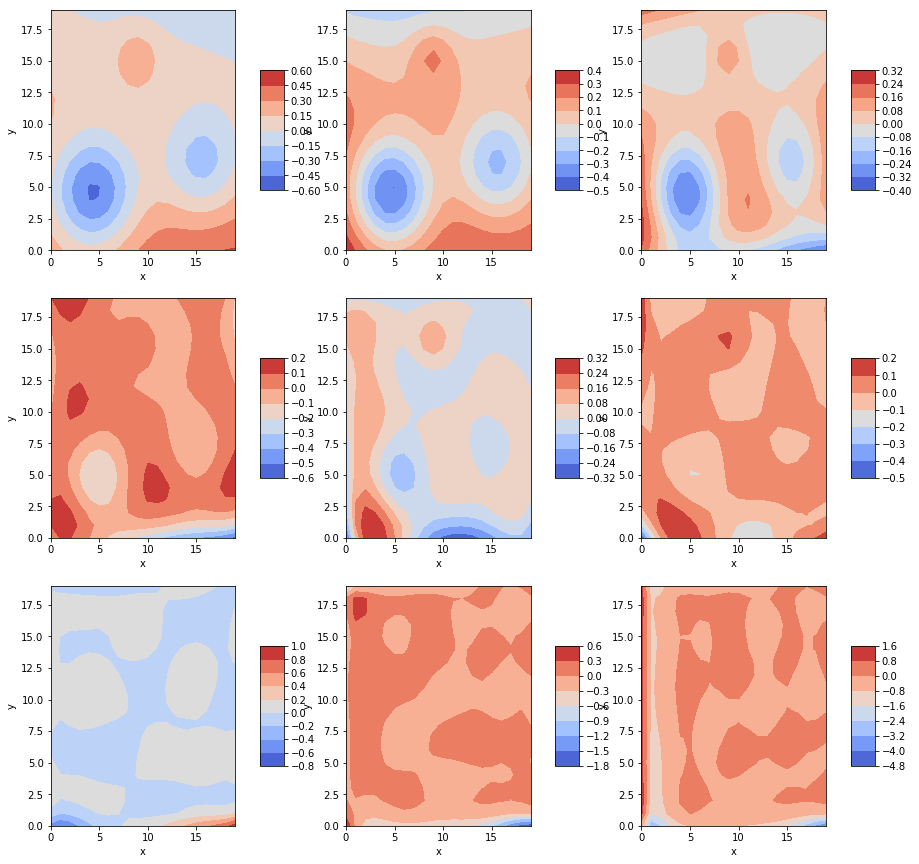

In [623]:
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
xp = np.arange(0,1,0.05)
yp = np.arange(0,1,0.05)
xp,yp = np.meshgrid(xp,yp,sparse=False)
xz,yz = np.meshgrid(xp,yp,sparse=True)
pd = 9
fz = FrankeFunction(xp,yp)
for i in range(pd):
    axs = fig.add_subplot(3,3,i+1)
    Xp = Model(xz,yz,i+1)
    zp = Xp@betas[i]
    zp.shape=(20,20)
#     plo = zp-fz
    plo = np.subtract(zp,fz)
#     print("a",zp[0],"b",fz[0],"c",plo[0])
    aa = axs.contourf(plo,cmap=cm.coolwarm)
#     axs.plot(plo[0],plo[1])
#     axs.plot_surface(xp,yp,zp,cmap=cm.coolwarm,linewidth=0,antialiased=False)
    axs.set_xlabel('x')
    axs.set_ylabel('y')
#     axs.addaxes(xp)
#     axs.set_zlabel('z')
#     axs.set_title('Polynomial degree = {}'.format(i+1))
#     axs.set_zlim(-0.10,1.40)
#     axs.zaxis.set_major_locator(LinearLocator(10))
#     axs.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig.colorbar(aa,shrink=0.5, aspect=5,pad = 0.1)

plt.show()

In [624]:
# ##FIND MODEL BETAS ONCE, THEN test NN times on those. seems not to work



# #Run NN kFolds to create bias/variance plot
# NN=5
# mpd = 10
# qq = len(z_n)

# #sort noisy signal
# z_n_sorted = sorted(z_n)

# #initialize variables 
# NMSE_k = np.zeros(shape=(NN,mpd)) #MSE stored for each run of kFold
# z_s = np.zeros(shape=(NN,mpd,qq))
# bias2 = np.zeros(mpd)
# var = np.zeros(mpd)
# bias2_ = np.zeros(shape=(mpd,qq))
# var_ = np.zeros(shape=(mpd,qq))
# NMSE = np.zeros(shape=(mpd))
# betass=[]
# for i in range(mpd):
#     X = Model(x,y,i+1)
#     beta = 0
#     for X_train, X_test, z_train, z_test in ksajjad(X,z_n,k):
#         beta += np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(z_train)
#     betass.append(beta/k)
# # mu =[]
# # #Run NN kFolds
# for i in range(mpd):
#     mu=[]
#     my=[]
#     X = Model(x,y,i+1)
# #     for l in range(NN):
# #     #shuffle here        
# #         X = Model(x,y,i+1)
#     X,z_n = Shuffler(X,z_n)
#     for X_train, X_test, z_train, z_test in ksajjad(X,z_n,k):

# #         XX,zz = Shuffler(X_test,z_test)
# #         X = Model(x,y,i+1)
# #         mu.append(XX@betass[i])
#         mu.append(X_test@betass[i])

# #         model_values[l,i] = kFoldskl(k,X,z_n)
# # #         model_values[l,i] = kFold(k,X,z_n)
# #         my.append(MSE(mu,zz))
#         my.append(MSE(mu,z_test))
#     NMSE[i] = np.mean(my)
# # print(my)
# #     NMSE[i] = MSE(np.array([mu]).ravel(),z_n)
# #     print(NMSE[i])
# # NMSE = np.mean(my,axis=0)
# # print(NMSE)
# # NMSE = np.mean(NMSE_k,axis=0)

# #Calculate bias and variance for each polynomial degree
# # for i in range(mpd):
# #     for m in range(qq):
# #         bias2_[i,m] = np.mean(z_s[:,i,m])
# #         var_[i,m] = np.var(z_s[:,i,m])
# #     bias2[i]=np.mean((z_n_sorted-bias2_[i])**2)
# #     var[i] = np.mean(var_[i])

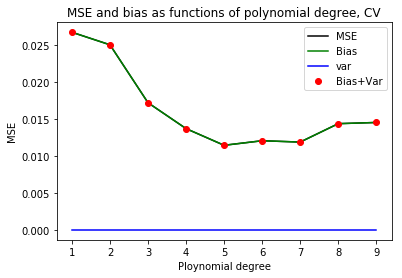

In [625]:
ols_noise = 8
legs = 'MSE','Bias','var','Bias+Var'
plt.figure()
maxi = 9
plt.plot(np.arange(1,maxi+1),NMSE[:maxi],'k')
plt.plot(np.arange(1,maxi+1),bias2[:maxi],'g')
plt.plot(np.arange(1,maxi+1),var[:maxi],'b')
plt.plot(np.arange(1,maxi+1),bias2[:maxi]+var[:maxi],'ro')
plt.xlabel('Ploynomial degree')
plt.ylabel('MSE')
plt.title('MSE and bias as functions of polynomial degree, CV')
plt.legend(legs)
plt.show()

In [626]:
def kFoldRidge(k,X,z_n,_lambda):
    #shuffle data before doing the kFold
    X,z_n = Shuffler(X,z_n)
    n = len(X[0,:])

    #initialize values
    z_test_per_fold = []
    z_tilde_per_fold = []
    sMSE = 0. #sum mean squared error
    sR2 = 0. #sum R2 score
    bets = 0
    for X_train, X_test, z_train, z_test in ksajjad(X,z_n,k):
        # find parameters
        beta = np.linalg.inv(X_train.T.dot(X_train)+_lambda*np.eye(n)).dot(X_train.T).dot(z_train)
        bets+= beta
        # make prediction
        z_tilde = X_test @ beta
        
        #store data per fold
        z_test_per_fold.append(z_test)
        z_tilde_per_fold.append(z_tilde)

    #prepare data before returning (sorting needed due to shuffles)
    z_test_per_fold = np.hstack(z_test_per_fold)
    z_tilde_per_fold = np.hstack(z_tilde_per_fold)
    order = np.argsort(z_test_per_fold)
    z_tilde_per_fold = z_tilde_per_fold[order]
    
    return z_tilde_per_fold,bets/k

In [662]:
print(z_n[0],z_n_sorted[0])
print(MSE(kFold(k,X,z_n)[0],z_n_sorted))
print(MSE(kFoldRidge(k,X,z_n,0.)[0],z_n_sorted))
print(MSE(kFoldskl(k,X,z_n)[0],z_n_sorted))
print(z_n[0],z_n_sorted[0])
# kFoldLassoCV(k,X,z_n,[-1,0,1])

0.8314910682022058 -0.14392819049451722
0.011438723886554997
0.03294268547632355
0.011438723798721639
0.8314910682022058 -0.14392819049451722


In [ ]:
def kFoldLassoCV(k,X,z_n,_lambda):
    partition = 0.2 #Percentage of data to use for testing

    #How to select good tolerances and max iters?
    reg = skl.LassoCV(alphas=_lambda,cv = k, random_state = 0,tol=0.0001,max_iter = 10000000).fit(X,z_n)
    ztilde = reg.predict(X)
#     plt.figure()
#     plt.semilogx(reg.alphas_,reg.mse_path_)
#     plt.semilogx(reg.alphas_,reg.mse_path_.mean(axis=-1),'k')
#     plt.xlabel('Log-plot of lambdas')
#     plt.ylabel('Mean squared error')
#     plt.show()
    
#     return mean_squared_error(ztilde,z_n), r2_score(ztilde,z_n)
#     return ztilde
    return mean_squared_error(ztilde,z_n), reg.coef_

In [ ]:
def kFoldLasso(k,X,z_n,_lambda):
    # this converges slowly for small lambda!
    
    #shuffle data before doing the kFold
    n = len(X[0,:])
    X,z_n = Shuffler(X,z_n)


    #initialize values
    z_test_per_fold = []
    z_tilde_per_fold = []
    sMSE = 0. #sum mean squared error
    sR2 = 0. #sum R2 score
    
    for X_train, X_test, z_train, z_test in ksajjad(X,z_n,k):
        # find parameters
        lass = skl.Lasso(alpha=_lambda,tol = 0.0001,max_iter=100000)
        lass.fit(X_train,z_train)
    
        #make prediction
        z_tilde = lass.predict(X_test)
        
        #store data per fold
        z_test_per_fold.append(z_test)
        z_tilde_per_fold.append(z_tilde)

    #prepare data before returning (sorting needed due to shuffles)
    z_test_per_fold = np.hstack(z_test_per_fold)
    z_tilde_per_fold = np.hstack(z_tilde_per_fold)
    order = np.argsort(z_test_per_fold)
    z_tilde_per_fold = z_tilde_per_fold[order]
    
    return z_tilde_per_fold

In [ ]:
print(MSE(kFoldRidge(k,X,z_n,10.)[0],z_n_sorted))
print(kFoldLassoCV(k,X,z_n,[10.])[0])
print(MSE(kFoldLasso(k,X,z_n,10.),z_n_sorted))

In [794]:
maxpd = 5
for i in range(maxpd):
    print("Polynomial degree", i+1)
    X = Model(x,y,i+1)
#     X = X-np.mean(X,axis=0)
#     X[:,0]=1.
#     z_n = z_n -np.mean(z_n)
    ztilde = kFold(k,X,z_n)[0]
    print("OLS")
    print("beta",kFold(k,X,z_n)[1])
    print("pm",1.96*np.sqrt(abs(Var(z_n, ztilde, i,X))))
    print("variance",Var(z_n,ztilde,i,X))
    ztilde = kFoldRidge(k,X,z_n,100.1)[0] #just a random lambda value
    print("Ridge")
    print("beta",kFoldRidge(k,X,z_n,0.1)[1])
    print("pm",1.96*np.sqrt(abs(Var(z_n, ztilde, i,X))))
#     print("variance",Var(z_n,ztilde,i,X))
    print("variance",VarRidge(X,10000.1))
    ztilde = kFoldLassoCV(k,X,z_n,[100.001,100.01])
    print("Lasso")
    print("beta",kFold(k,X,z_n)[1])
    print("pm",1.96*np.sqrt(abs(Var(z_n, ztilde, i,X))))
    print("variance",Var(z_n,ztilde,i,X))
    print("-------------------")
    ### ALL VARIANCES ARE THE SAME, WHY?!?!

Polynomial degree 1
OLS
beta [ 0.97786487 -0.47517365 -0.70339717]
pm [0.26698867 0.37296091 0.36266242]
variance [0.01855554 0.03620883 0.03423678]
Ridge
beta [ 0.985974   -0.48930881 -0.70089795]
pm [0.26698867 0.37296091 0.36266242]
variance [9.62188606e-05 9.88011237e-05 9.89206568e-05]
Lasso
beta [ 1.00154704 -0.49973379 -0.71792096]
pm [0.26698867 0.37296091 0.36266242]
variance [0.01855554 0.03620883 0.03423678]
-------------------
Polynomial degree 2
OLS
beta [ 1.07513878 -0.84971368 -0.03626433 -0.5228225   0.87060205 -0.62936896]
pm [0.52508293 1.41015671 1.19782114 1.65725956 1.38019292 1.52065599]
variance [0.07177012 0.51763379 0.37348383 0.71493889 0.49586956 0.6019353 ]
Ridge
beta [ 1.05499289 -0.74720741 -0.09016799 -0.54969582  0.76498599 -0.55051826]
pm [0.52508293 1.41015671 1.19782114 1.65725956 1.38019292 1.52065599]
variance [9.62510110e-05 9.88141309e-05 9.93304779e-05 9.89321342e-05
 9.96617084e-05 9.94189599e-05]
Lasso
beta [ 1.08343621 -0.81873869 -0.05557923 

# c

In [628]:
_lams = np.logspace(-4,0,10)
kFoldLassoCV(k,X,z_n,_lams)

(0.015184467033469127,
 array([ 0.        , -0.51704867, -1.66317452,  0.        ,  1.72062943,
         0.        , -0.        , -0.        , -0.        , -0.61552257,
        -0.27334081,  0.        ,  2.31384283,  0.61416175,  0.        ,
         0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -2.15833002, -2.12339412, -0.        , -0.        ,
        -0.15052968, -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        ,  0.        ,  0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
         1.87045967,  0.        ,  0.        ,  0.        , -0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.04091248,  0.        ,  0.        ,
        -0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        -0.25774584]))

In [629]:
MPD = np.arange(9)+1#np.arange(9)+1
MSE_degree = []


#shuffle data before doing the kFold
# n = len(X[0,:])
# combi = np.c_[X,z_n]
# np.random.shuffle(combi)
# X, z_n = combi[:,:n], combi[:,n]
# X_new,z_n_new = Shuffler(X,z_n)
for i in MPD:
    X = Model(x,y,i)
    
    z_out = kFold(k,X,z_n)
#     dMSE, dR2 = NoResampling(X,z_n,0)
#     dMSE,dR2 = kFoldskl(k,X,z_n)
#     print(i,dMSE)
    MSE_degree.append(MSE(z_out,z_n_sorted))
# MS = MSE(MSE_degree,z_n)

TypeError: unsupported operand type(s) for -: 'tuple' and 'list'

ValueError: x and y must have same first dimension, but have shapes (9,) and (0,)

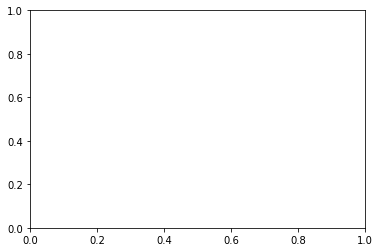

In [630]:
plt.figure()
plt.plot(MPD+1,MSE_degree)
plt.xlabel('Polynomial degree')
plt.ylabel('Mean squared error')
plt.show()

# d

In [631]:
_lambda = np.logspace(-4,5,10)

RidgeMSE = np.zeros((len(MPD),len(_lambda)))
RidgeR2 = np.zeros((len(MPD),len(_lambda)))



for i,mpd in enumerate(MPD):
    X = Model(x,y,mpd)
    for j,lam in enumerate(_lambda):
#         rMSE,rR2 = NoResampling(X,z_n,lam)
        z_out = kFoldRidge(k,X,z_n,lam)
        RidgeMSE[i][j] = MSE(z_out,z_n_sorted)
        RidgeR2[i][j] = R2(z_n_sorted,z_out)

TypeError: unsupported operand type(s) for -: 'tuple' and 'list'

/home/janfki/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


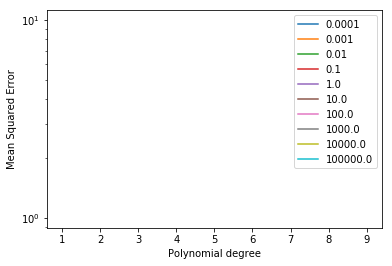

In [632]:
plt.figure()

for i in range(len(_lambda)):
    plt.semilogy(MPD,RidgeMSE[:,i],label=_lambda[i])
plt.xlabel('Polynomial degree')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

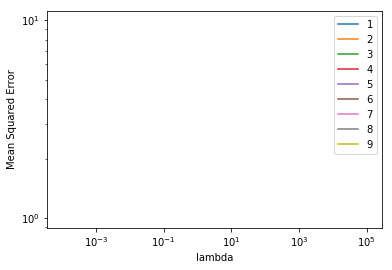

In [633]:
plt.figure()

for i in range(len(MPD)):
    plt.loglog(_lambda,RidgeMSE[i,:],label=i+1)
plt.xlabel('lambda')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# e

In [634]:
# I'll use Scikit-learn as recommended for this
kFoldLassoCV(k,X,z_n,_lambda)


(0.02620941117071891, array([ 0.        , -0.38235849, -0.71484432]))

In [635]:
terrain = imread('SRTM_data_Norway_1.tif')
terr_square = terrain[0:100,0:100]
print(np.shape(terr_square))

(100, 100)


In [636]:
terra = np.matrix.flatten(terr_square)
print(np.shape(terra))
# x = np.linspace(0,len(terr_square[0]),100)
# y = np.linspace(0,len(terr_square[1]),100)
x = np.linspace(0,1,np.sqrt(len(terra)))
y=np.linspace(0,1,np.sqrt(len(terra)))
x, y = np.meshgrid(x,y,sparse=False)


(10000,)


/home/janfki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  """
/home/janfki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  


In [471]:
X = Model(x,y,5)


X_c = X-np.mean(X,axis=0)
X_c[:,0]=1.
terra_c = terra -np.mean(terra)

In [472]:
NoResampling(X,terra,0.)

(468.60889033983835, 0.9038759259415522)

In [477]:
betas=[]
mpd = 6
for i in range(mpd):
        X = Model(xp,yp,i+1)
        print(np.shape(X))
#         model_values[l,i] = kFoldskl(k,X,z_n)[0]
#         model_values[l,i] = kFold(k,X,z_n)[0]
#         NMSE_k[l,i] = MSE(model_values[l,i],z_n_sorted)
#         if l == 0:
        betas.append(kFold(k,X,terra)[1])

(10000, 3)
(10000, 6)
(10000, 10)
(10000, 15)
(10000, 21)
(10000, 28)


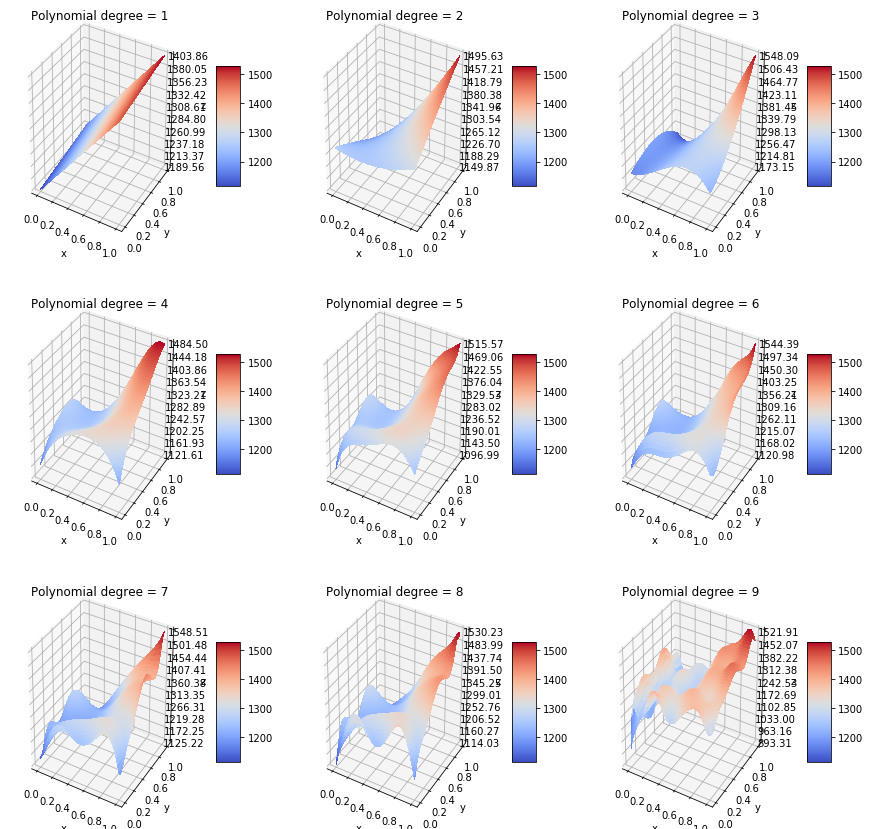

In [478]:
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
# xp = np.arange(0,1,0.05)
# yp = np.arange(0,1,0.05)


xp = np.linspace(0,1,len(terr_square[0]))
yp=np.linspace(0,1,len(terr_square[1]))

xp,yp = np.meshgrid(xp,yp,sparse=False)
xz,yz = np.meshgrid(xp,yp,sparse=True)
pd = 9
# fz = FrankeFunction(xp,yp)


betas=[]
for i in range(pd):
        X = Model(xp,yp,i+1)
        betas.append(kFold(k,X,terra)[1])

for i in range(pd):
    axs = fig.add_subplot(3,3,i+1,projection='3d')
    Xp = Model(xp,yp,i+1)
    zp = Xp@betas[i]
    zp.shape=(len(xp),len(yp))
    axs.plot_surface(xp,yp,zp,cmap=cm.coolwarm,linewidth=0,antialiased=False)
#     axs.plot_surface(xp,yp,terr_square,cmap=cm.coolwarm,linewidth=0,antialiased=False)
    axs.set_xlabel('x')
    axs.set_ylabel('y')
    axs.set_zlabel('z')
    axs.set_title('Polynomial degree = {}'.format(i+1))
#     axs.set_zlim(-0.10,1.40)
    axs.zaxis.set_major_locator(LinearLocator(10))
    axs.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig.colorbar(surf,shrink=0.5, aspect=5,pad = 0.1)

plt.show()

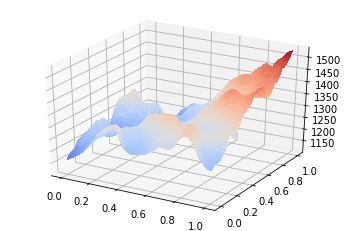

In [479]:
fig2 = plt.figure()
axers = fig2.gca(projection='3d')

for i in range(pd):
    surf = axers.plot_surface(xp,yp,terr_square,cmap=cm.coolwarm,linewidth=0,antialiased=False)
plt.show()

In [638]:
pd = 5
_lams = np.linspace(0.0,1.,10)
X = Model(x,y,pd)
fish=[]
for i in range(len(_lams)):
    fish.append(kFoldRidge(k,X,z_n,i))

[[0.         0.01010101 0.02020202 ... 0.97979798 0.98989899 1.        ]
 [0.         0.01010101 0.02020202 ... 0.97979798 0.98989899 1.        ]
 [0.         0.01010101 0.02020202 ... 0.97979798 0.98989899 1.        ]
 ...
 [0.         0.01010101 0.02020202 ... 0.97979798 0.98989899 1.        ]
 [0.         0.01010101 0.02020202 ... 0.97979798 0.98989899 1.        ]
 [0.         0.01010101 0.02020202 ... 0.97979798 0.98989899 1.        ]]


ValueError: all the input array dimensions except for the concatenation axis must match exactly